In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter

In [2]:
def build_seir_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=("Infectious",),
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["tot_popn"] - config["infectious_seed"],
            "Infectious": config["infectious_seed"],
        }
    )

    # Transitions
    ave_infous = Parameter("ave_infous")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("R0") / ave_infous,
        source="Susceptible",
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("ave_preinfous"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / ave_infous,
        source="Infectious", 
        dest="Immune"
    )

    # Outputs
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression",
        raw_results=True,
    )
    model.request_output_for_flow(
        name="infection", 
        flow_name="infection",
        raw_results=True,
    )
    return model

In [3]:
model_config = {
    "tot_popn": 1e5,
    "infectious_seed": 1.,
    "end_time": 200.,
}

parameters = {
    "ave_preinfous": 2.,
    "ave_infous": 2.,
    "R0": 2.,
}

In [4]:
seir_model = build_seir_model(model_config)
seir_model.run(parameters=parameters)
seir_compartments = seir_model.get_outputs_df()

#### Figure 1 on the left

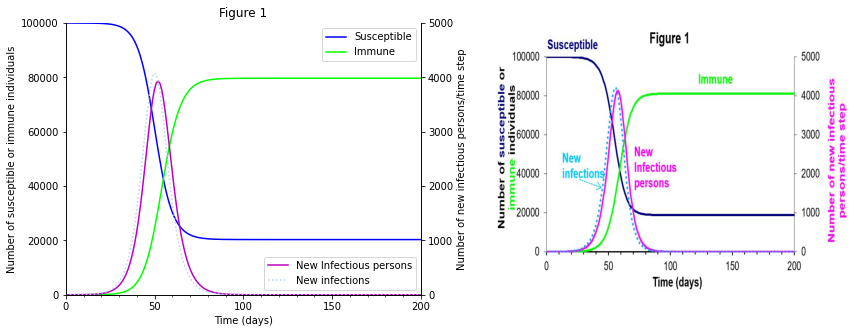

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

left_ax.set_xlabel("Time (days)")
left_ax.set_ylim(0, 1e5)
left_ax.set_ylabel("Number of susceptible or immune individuals")
left_ax.plot(seir_compartments["Susceptible"], color="b", label="Susceptible")
left_ax.plot(seir_compartments["Immune"], color="lime", label="Immune")
left_ax.legend()
left_ax.spines.top.set_visible(False)
left_ax.set_xticks(range(0, 250, 50))
left_ax.set_xlim(0., 200.)
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_title("Figure 1")

twin_ax.set_ylim((0, 5000))
twin_ax.set_ylabel("Number of new infectious persons/time step")
twin_ax.set_yticks(range(0, 6000, 1000))
twin_ax.plot(seir_model.derived_outputs["incidence"], color="m", label="New Infectious persons")
twin_ax.plot(seir_model.derived_outputs["infection"], color="lightblue", linestyle=":", label="New infections")
twin_ax.legend(loc=4)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/model_2_1a_fig_1.JPG")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");

In [6]:
def build_sir_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = ("Susceptible", "Infectious", "Immune")
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["tot_popn"] - config["infectious_seed"],
            "Infectious": config["infectious_seed"],
        }
    )

    # Transitions
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("R0") / Parameter("ave_infous"),
        source="Susceptible", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / Parameter("ave_infous"), 
        source="Infectious", 
        dest="Immune"
    )
    
    # Output
    model.request_output_for_flow(
        name="incidence",
        flow_name="infection",
        raw_results=True,
    )
    return model

In [7]:
sir_model = build_sir_model(model_config)
sir_model.run(parameters=parameters)
sir_compartments = sir_model.get_outputs_df()

#### Figure 2 on the right

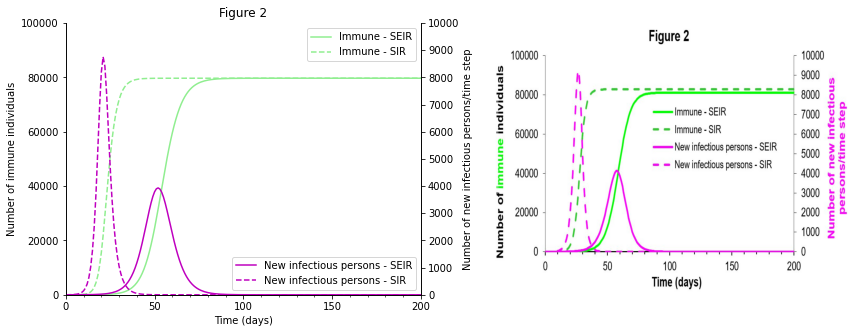

In [8]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

left_ax.plot(seir_compartments["Immune"], color="lightgreen", label="Immune - SEIR")
left_ax.plot(sir_compartments["Immune"], color="lightgreen", linestyle="--", label="Immune - SIR")
left_ax.set_xlabel("Time (days)")
left_ax.set_xticks(range(0, 250, 50))
left_ax.set_xlim(0., 200.)
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_ylim(0, 1e5)
left_ax.set_ylabel("Number of immune individuals")
left_ax.legend()
left_ax.spines.top.set_visible(False)
left_ax.set_title("Figure 2")

twin_ax.plot(seir_model.derived_outputs["incidence"], color="m", label="New infectious persons - SEIR")
twin_ax.plot(sir_model.derived_outputs["incidence"], color="m", linestyle="--", label="New infectious persons - SIR")
twin_ax.set_ylim(0, 1e4)
twin_ax.set_yticks(range(0, 11000, 1000))
twin_ax.set_ylabel("Number of new infectious persons/time step")
twin_ax.legend(loc=4)
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/model_2_1a_fig_2.JPG")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");